In [1]:
# !pip install transformers datasets seqeval

In [6]:
from datasets import Dataset, DatasetDict
import pandas as pd

def read_conll(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    tokens, labels = [], []
    current_tokens, current_labels = [], []

    for line in lines:
        line = line.strip()
        if line:
            token, label = line.split()  # Assuming space-separated
            current_tokens.append(token)
            current_labels.append(label)
        else:
            if current_tokens:
                tokens.append(current_tokens)
                labels.append(current_labels)
                current_tokens, current_labels = [], []

    # Add the last sentence if file doesn't end with newline
    if current_tokens:
        tokens.append(current_tokens)
        labels.append(current_labels)

    return {"tokens": tokens, "ner_tags": labels}

# Load data
data = read_conll("data.txt")
df = pd.DataFrame(data)

# Split 80/20
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

# Convert to Dataset
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")

# Map labels to IDs
label_list = sorted(list(set(tag for tags in data["ner_tags"] for tag in tags)))
label2id = {tag: i for i, tag in enumerate(label_list)}

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )

    labels = []
    for i, tags in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[tags[word_idx]])
            else:
                label_ids.append(-100)  # For subword tokens
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/2533 [00:00<?, ? examples/s]

Map:   0%|          | 0/633 [00:00<?, ? examples/s]

In [14]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
from seqeval.metrics import classification_report, accuracy_score

# Define label mappings (must run after loading data)
label_list = sorted(list(set(tag for tags in data["ner_tags"] for tag in tags)))
label2id = {tag: i for i, tag in enumerate(label_list)}
id2label = {i: tag for tag, i in label2id.items()}

# Initialize model
model = AutoModelForTokenClassification.from_pretrained(
    "FacebookAI/xlm-roberta-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./ner_results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
)

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for l in label if l != -100]
        for label in labels
    ]

    # Calculate metrics
    results = classification_report(true_labels, true_predictions, output_dict=True)
    accuracy = accuracy_score(true_labels, true_predictions)

    return {
        "precision": results["macro avg"]["precision"],
        "recall": results["macro avg"]["recall"],
        "f1": results["macro avg"]["f1-score"],
        "accuracy": accuracy,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.038275,0.946848,0.947995,0.947346,0.990592
2,No log,0.032723,0.953930,0.967022,0.960357,0.992149
3,No log,0.026255,0.964415,0.974384,0.969308,0.994799
4,0.068700,0.022819,0.973344,0.974525,0.973908,0.995362
5,0.068700,0.024623,0.974158,0.978454,0.976265,0.995528


TrainOutput(global_step=795, training_loss=0.045293404321250674, metrics={'train_runtime': 915.666, 'train_samples_per_second': 13.831, 'train_steps_per_second': 0.868, 'total_flos': 827353295558400.0, 'train_loss': 0.045293404321250674, 'epoch': 5.0})

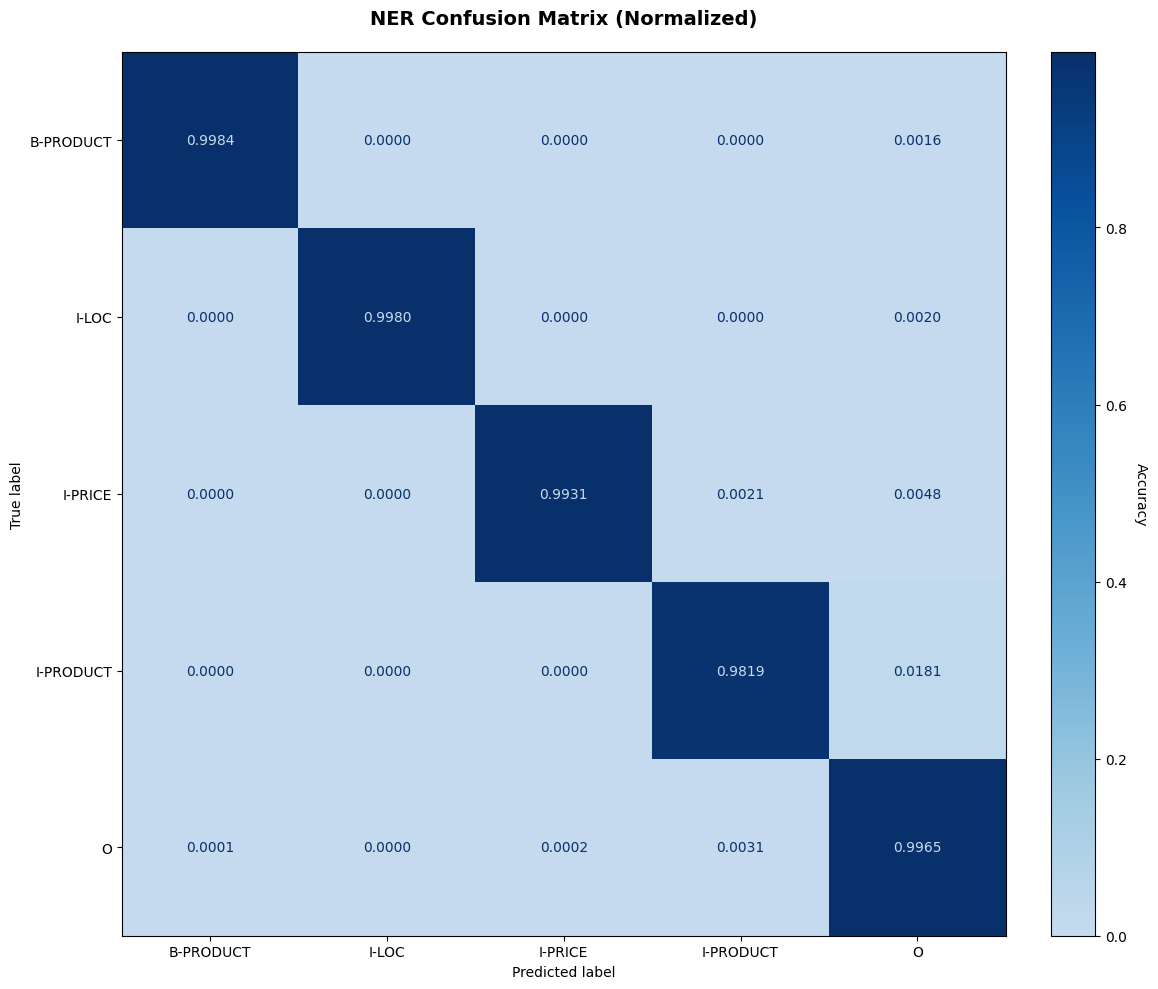

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

# Get predictions
predictions = trainer.predict(tokenized_datasets["validation"])
preds = np.argmax(predictions.predictions, axis=2)

# Flatten labels and preds (ignore -100)
true_labels = [label for batch in predictions.label_ids for label in batch if label != -100]
flat_preds = [pred for batch, labels in zip(preds, predictions.label_ids)
              for pred, label in zip(batch, labels) if label != -100]

# Create confusion matrix
cm = confusion_matrix(true_labels, flat_preds, normalize="true")

# Create blue-white colormap
blue_colors = plt.cm.Blues(np.linspace(0, 1, 256))
white_blue_colors = blue_colors[64:]  # Skip the very light blues
cmap = matplotlib.colors.ListedColormap(white_blue_colors)

# Plot with custom styling
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_list
)
disp.plot(
    cmap=cmap,
    ax=ax,
    values_format=".4f",
    colorbar=False,
)

# Add title and adjust layout
plt.title("NER Confusion Matrix (Normalized)", pad=20, fontsize=14, weight='bold')
plt.tight_layout()

# Add colorbar
cbar = plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Accuracy', rotation=270, labelpad=15)

plt.show()

In [16]:
model.save_pretrained("./amharic_ner_model")
tokenizer.save_pretrained("./amharic_ner_model")

('./amharic_ner_model/tokenizer_config.json',
 './amharic_ner_model/special_tokens_map.json',
 './amharic_ner_model/sentencepiece.bpe.model',
 './amharic_ner_model/added_tokens.json',
 './amharic_ner_model/tokenizer.json')

In [35]:
from transformers import pipeline

# 1. Load your saved model
ner_model = pipeline(
    task="ner",
    model="./amharic_ner_model",  # Path to your saved model
    tokenizer="./amharic_ner_model",  # Path to your saved tokenizer
    aggregation_strategy="simple",  # Groups subwords into whole words
    device=0  # Use GPU (set to -1 for CPU)
)

# 2. Test text (replace with your Amharic text)
test_text = "3pcs silicon brush ዋጋ-550ብር መገናኛ #ዛም_ሞል"

# 3. Get predictions
results = ner_model(test_text)

# 4. Print formatted results
print(f"\nInput Text: '{test_text}'\n")
print("Detected Entities:")
for entity in results:
    print(f"""
    Entity: {entity['word']}
    Type: {entity['entity_group']}
    Confidence: {entity['score']:.2%}
    Position: Characters {entity['start']}-{entity['end']}
    """)

# 5. Extract specific entity types
print("\nSummary:")
print(f"Products: {[e['word'] for e in results if e['entity_group'] == 'PRODUCT']}")
print(f"Prices: {[e['word'] for e in results if e['entity_group'] == 'PRICE']}")
print(f"Locations: {[e['word'] for e in results if e['entity_group'] == 'LOCATION']}")

Device set to use cuda:0



Input Text: '3pcs silicon brush ዋጋ-550ብር መገናኛ #ዛም_ሞል'

Detected Entities:

    Entity: 3pcs silicon brush
    Type: PRODUCT
    Confidence: 99.88%
    Position: Characters 0-18
    

    Entity: ዋጋ-550ብር
    Type: PRICE
    Confidence: 99.11%
    Position: Characters 19-27
    

    Entity: መ
    Type: LOC
    Confidence: 93.07%
    Position: Characters 28-29
    

Summary:
Products: ['3pcs silicon brush']
Prices: ['ዋጋ-550ብር']
Locations: []


In [37]:
!zip -r final.zip amharic_ner_model

  adding: amharic_ner_model/ (stored 0%)
  adding: amharic_ner_model/model.safetensors (deflated 29%)
  adding: amharic_ner_model/special_tokens_map.json (deflated 52%)
  adding: amharic_ner_model/sentencepiece.bpe.model (deflated 49%)
  adding: amharic_ner_model/config.json (deflated 51%)
  adding: amharic_ner_model/tokenizer.json (deflated 76%)
  adding: amharic_ner_model/tokenizer_config.json (deflated 76%)
